In [41]:
def get_CNN_param(cnn_day, TAIEX_df, Triple_day , hasTurning_point, TAIEX_bias_df , isBias ,threshold =0.65) :
     
    def training (): 
        day = cnn_day
        df = TAIEX_df[::-1].reset_index(drop=True)
        ret = fn.triple_barrier(TAIEX_df.Close, Triple_up ,Triple_down, Triple_day)

        if isBias :        
            dropLabel = ['STOCK_ID','Date']
            #dropLabel = ['Volume','Dividends','Stock Splits','STOCK_ID','Date']
        else :
            dropLabel=['Date', 'Volume','Dividends','Stock Splits','STOCK_ID','Adj Close']

        if hasTurning_point : 
            turning_date = fn.get_turning_point(df ,TAIEX_df, day)        
            start = 0 
            long_list = []
            long_label = []
            hasTurningPoint= []

            for i in turning_date:
                if start == 0 :
                    start = i[0]
                    continue
                if isBias :
                    split_data = TAIEX_bias_df[start+1 : i[0]+1].drop(dropLabel,axis=1)[::-1].reset_index(drop = True)
                else :
                    split_data = TAIEX_df[start+1 : i[0]+1].drop(dropLabel,axis=1)[::-1].reset_index(drop = True)
                long_list.extend(fn.get_series_data(split_data , day , False, isBias))
                long_label.extend(ret.triple_barrier_signal[start+day : i[0]+1][::-1])   
                start = i[0]
            long_list = np.array(long_list)
        else :
            if isBias : 
                df = TAIEX_bias_df[::-1].reset_index(drop=True)
                price_df = df.drop(dropLabel,axis=1)
            else :
                price_df = df.drop(dropLabel,axis=1)
            long_list = fn.get_series_data(price_df , day , False, isBias)
            long_label = ret.triple_barrier_signal[day-1:len(ret)]

        print(pd.Series(long_label).value_counts())
        balance= max(pd.Series(long_label).value_counts())/len(long_label)

        ## CNN Training by split data
        model, acc_list = cnn_training(long_list,long_label , day , 0.5 , 20 ,threshold)
        
        print("Param score: ", max(acc_list)/balance + max(acc_list)/2)
        
        return max(acc_list)/balance + max(acc_list)/2
    
    Triple_down_list = [0.98,0.975,0.97,0.965,0.96]
    Triple_up_list = [1.02,1.025,1.03,1.035,1.04,1.045,1.05]
    Triple_up = Triple_up_list[math.ceil(Triple_day**0.7)] ;
    
    score_list = []
    for Triple_down in Triple_down_list :        
        score_list.append(training())
    Triple_down = Triple_down_list[score_list.index(max(score_list))]
    
    score_list = []
    for Triple_up in Triple_up_list :        
        score_list.append(training())
    Triple_up = Triple_up_list[score_list.index(max(score_list))]
    
    print("best down:" ,Triple_down)
    print("best up:" ,Triple_up)
    
    return Triple_up, Triple_down 
    


In [115]:
import numpy as np
from sklearn import preprocessing
from numpy import random
import time

def tansig(x):
    return (2/(1+np.exp(-2*x)))-1

def pinv(A,reg):
    return np.mat(reg*np.eye(A.shape[1])+A.T.dot(A)).I.dot(A.T)


'''
参数压缩
'''
def shrinkage(a,b):
    z = np.maximum(a - b, 0) - np.maximum( -a - b, 0)
    return z
'''
参数稀疏化
'''
def sparse_bls(A,b):
    lam = 0.001
    itrs = 50
    AA = np.dot(A.T,A)   
    m = A.shape[1]
    n = b.shape[1]
    wk = np.zeros([m,n],dtype = 'double')
    ok = np.zeros([m,n],dtype = 'double')
    uk = np.zeros([m,n],dtype = 'double')
    L1 = np.mat(AA + np.eye(m)).I
    L2 = np.dot(np.dot(L1,A.T),b)
    for i in range(itrs):
        tempc = ok - uk
        ck =  L2 + np.dot(L1,tempc)
        ok = shrinkage(ck + uk, lam)
        uk += ck - ok
        wk = ok
    return wk

def bls_regression(train_x,train_y,test_x,test_y,s,C,NumFea,NumWin,NumEnhan):

    train_x = train_x
    u = 0
    WF = list()
    for i in range(NumWin):
        random.seed(i+u)
        WeightFea=2*random.randn(train_x.shape[1]+1,NumFea)-1;
        WF.append(WeightFea)
#    random.seed(100)
    WeightEnhan=2*random.randn(NumWin*NumFea+1,NumEnhan)-1;
    time_start = time.time()
    H1 = np.hstack([train_x, 0.1 * np.ones([train_x.shape[0],1])]);
    y = np.zeros([train_x.shape[0],NumWin*NumFea])
    WFSparse = list()
    distOfMaxAndMin = np.zeros(NumWin)
    meanOfEachWindow = np.zeros(NumWin)
    for i in range(NumWin):
        WeightFea = WF[i]
        A1 = H1.dot(WeightFea)        
        scaler1 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(A1)
        A1 = scaler1.transform(A1)
        WeightFeaSparse  = sparse_bls(A1,H1).T
        WFSparse.append(WeightFeaSparse)
    
        T1 = H1.dot(WeightFeaSparse)
        meanOfEachWindow[i] = T1.mean()
        distOfMaxAndMin[i] = T1.max() - T1.min()
        T1 = (T1 - meanOfEachWindow[i])/distOfMaxAndMin[i] 
        y[:,NumFea*i:NumFea*(i+1)] = T1

    H2 = np.hstack([y,0.1 * np.ones([y.shape[0],1])])
    T2 = H2.dot(WeightEnhan)
    T2 = tansig(T2);
    T3 = np.hstack([y,T2])
    WeightTop = pinv(T3,C).dot(train_y).T

    Training_time = time.time()- time_start
#     print('Training has been finished!');
#     print('The Total Training Time is : ', round(Training_time,6), ' seconds' )
    NetoutTrain = np.resize(T3.dot(WeightTop) ,y.shape[0])
#     print(NetoutTrain)
#     print(train_y)
#     print((NetoutTrain-train_y))
#     print((NetoutTrain-train_y).T*(NetoutTrain-train_y))
    MSE = sum((NetoutTrain-train_y).T*(NetoutTrain-train_y))/train_y.shape[0]
    RMSE = np.sqrt((NetoutTrain-train_y).T*(NetoutTrain-train_y)/train_y.shape[0])
    MAPE = sum(abs(NetoutTrain-train_y))/train_y.mean()/train_y.shape[0]
    train_ERR = RMSE
    train_MAPE = MAPE
    
#     print('Training MSE is : ',mean_squared_error(train_y, NetoutTrain, squared=False))
#     print('Training RMSE is : ',RMSE.mean());
#     print('Training MAPE is : ', MAPE)
    time_start = time.time()
    HH1 = np.hstack([test_x, 0.1 * np.ones([test_x.shape[0],1])])
    yy1=np.zeros([test_x.shape[0],NumWin*NumFea])
    for i in range(NumWin):
        WeightFeaSparse = WFSparse[i]
        TT1 = HH1.dot(WeightFeaSparse)
        TT1  = (TT1 - meanOfEachWindow[i])/distOfMaxAndMin[i]   
        yy1[:,NumFea*i:NumFea*(i+1)] = TT1

    HH2 = np.hstack([yy1, 0.1 * np.ones([yy1.shape[0],1])])
    TT2 = tansig(HH2.dot( WeightEnhan));
    TT3 = np.hstack([yy1,TT2])
    NetoutTest = np.resize( TT3.dot(WeightTop), test_x.shape[0])
    MSE = sum((NetoutTest-test_y).T*(NetoutTest-test_y))/test_y.shape[0]
    RMSE = np.sqrt((NetoutTest-test_y).T*(NetoutTest-test_y)/test_y.shape[0])
    MAPE = sum(abs(NetoutTest-test_y))/test_y.mean()/test_y.shape[0]
    test_ERR = RMSE
    test_MAPE = MAPE
#%% Calculate the testing accuracy
    Testing_time = time.time() - time_start
#     print('Testing has been finished!');
#     print('The Total Testing Time is : ', round(Testing_time,6), ' seconds' )
#     print('Testing MSE is : ',mean_squared_error(test_y, NetoutTest, squared=False))
#     print('Testing RMSE is : ', RMSE.mean()) 
#     print('Testing MAPE is : ', MAPE.mean())
    return NetoutTrain, NetoutTest



def get_median_mse( prediction_x, prediction_y, true_location_x, true_location_y, true_label):
    location = pd.Series(true_label, dtype="category").cat.categories.tolist()
    predit_pos = []
    true_pos = []
    for l in location :
        predit_pos.append([np.percentile(prediction_x[true_label == l ], 50), np.percentile(prediction_y[true_label == l ], 50)])
        true_pos.append([true_location_x[true_label == l].mean(),true_location_y[true_label == l].mean()])
    print('MSE is : ',mean_squared_error(np.array(predit_pos), np.array(true_pos), squared=False))
    print('MSE is : ',mean_absolute_error(np.array(predit_pos), np.array(true_pos)))
    return mean_squared_error(np.array(predit_pos), np.array(true_pos), squared=False), mean_absolute_error(np.array(predit_pos), np.array(true_pos))

import numpy as np
import scipy.io as scio
import seaborn as sn
from sklearn.metrics import mean_squared_error, mean_absolute_error

def localization(NumFea ,NumWin,NumEnhan,s,C , data , label):
#     NumFea = 20
#     NumWin = 20
#     NumEnhan = 300
#     s = 0.8
#     C = 2**-30
    ratio = 0.5
    BLS_train = data[:math.ceil(len(data)*0.5)]
    BLS_test = data[math.ceil(len(data)*0.5):math.ceil(len(data)*0.7)]
    
    BLS_train_y = label[:math.ceil(len(data)*0.5)]
    BLS_test_y = label[math.ceil(len(data)*0.5):math.ceil(len(data)*0.7)]
    
    train_scale_X = (BLS_train-BLS_train.mean())/BLS_train.std()
    test_scale_X = (BLS_test-BLS_train.mean())/BLS_train.std()
    
    train_return , test_return = bls_regression(train_scale_X, BLS_train_y,
               test_scale_X, BLS_test_y,s,C,NumFea,NumWin,NumEnhan)
    
#     print('Train MSE is : ',mean_squared_error(np.array(train_return), np.array(BLS_train_y), squared=False))
#     print('Test MSE is  : ',mean_squared_error(np.array(test_return), np.array(BLS_test_y), squared=False))
    
    over_pre_score = []
    for r, t in zip(test_return, BLS_test_y) :
        if r > 0 and r > t :
            over_pre_score.append((r-t)**2)
        elif r < 0 and r < t :
            over_pre_score.append((r-t)**2)
        else :
            over_pre_score.append(0)
    

    return np.array(over_pre_score).mean(), mean_absolute_error(np.array(test_return), np.array(BLS_test_y))
#     return get_median_mse(test_pos_x, test_pos_y, data_test[0]['pos_x'], data_test[0]['pos_y'], data_test[0]['y'].values)

In [116]:
def cnn_training(allData, allLabel, day , splitsize, epoches = 100 , threshold = 0.45) :
    score = 0
    acc_list = []
    iter = 0
    model_list = []
    while score < threshold and iter < 10 :          
        week_list = allData
        week_label = allLabel
        # 定義梯度下降批量
        batch_size = 32
        # 定義分類數量
        num_classes = 3
        # 定義訓練週期
        epochs = epoches

        # 定義圖像寬、高
        img_rows, img_cols = day, 4
        input_shape = ( img_rows, img_cols)

        # 載入 MNIST 訓練資料
        split_ratio = splitsize
        x_train = week_list[ math.ceil(len(week_list)*split_ratio) :]
        x_test = week_list[ math.ceil(len(week_list)*split_ratio*0.4) : math.ceil(len(week_list)*split_ratio) ]

        y_train = week_label[ math.ceil(len(week_label)*split_ratio) :]
        y_test = week_label[ math.ceil(len(week_list)*split_ratio*0.4)  : math.ceil(len(week_label)*split_ratio) ]

        x_train = x_train.reshape(x_train.shape[0] , img_rows, img_cols,1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols ,1)

        # x_train  = torch.from_numpy(x_train)
        # x_test  = torch.from_numpy(x_test)

        # y_train = torch.from_numpy(y_train)
        # y_test = torch.from_numpy(y_test)

        input_shape = (img_rows, img_cols,1 )

        # 保留原始資料，供 cross tab function 使用
        y_test_org = y_test


        # y 值轉成 one-hot encoding
        y_train = np_utils.to_categorical(y_train, num_classes)
        y_test = np_utils.to_categorical(y_test, num_classes)

        # 建立簡單的線性執行的模型
        model = Sequential()
        # 建立卷積層，filter=32,即 output space 的深度, Kernal Size: 3x3, activation function 採用 relu
        model.add(Conv2D(16, kernel_size=(3,2),
                        activation='relu',
                        input_shape=input_shape))
        # 建立池化層，池化大小=2x2，取最大值
        #model.add(BatchNormalization())
        model.add(GaussianNoise(0.3))
        # 建立卷積層，filter=64,即 output size, Kernal Size: 3x3, activation function 採用 relu
        model.add(Conv2D(32,  kernel_size=(3,2), activation='relu'))
        # 建立池化層，池化大小=2x2，取最大值
        model.add(AvgPool2D(pool_size=(3, 2)))
        # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25
        model.add(Dropout(0.25))
        # Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
        model.add(Flatten( name ='flatten'))
        # 全連接層: 128個output
        model.add(Dense(batch_size, 'sigmoid', name ='Dense'))
        # 使用 softmax activation function，將結果分類
        model.add(Dense(num_classes, activation='softmax' ))

        # 編譯: 選擇損失函數、優化方法及成效衡量方式
        model.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer='adam',
                    metrics=['accuracy'])

        # 進行訓練, 訓練過程會存在 train_history 變數中
        train_history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_test, y_test))

        # 顯示損失函數、訓練成果(分數)
        score = model.evaluate(x_test, y_test, verbose=0)
        print('Test accuracy:', score)
        acc_list.append(score[1])
        iter +=1
        score = score[1]
        model_list.append(model)
    print ("best model with acc : " ,max(acc_list))
    return model_list[acc_list.index(max(acc_list))], acc_list

In [182]:
def get_CNN_cluster(cnn_day, TAIEX_df, Triple_up , Triple_down, Triple_day , num_cluster, hasTurning_point, TAIEX_bias_df , isBias ,threshold =0.45) :
    day = cnn_day
    df = TAIEX_df[::-1].reset_index(drop=True)
    ret = fn.triple_barrier(TAIEX_df.Close, Triple_up ,Triple_down, Triple_day)
    
    if isBias :        
        dropLabel = ['STOCK_ID','Date']
        #dropLabel = ['Volume','Dividends','Stock Splits','STOCK_ID','Date']
    else :
        dropLabel=['Date', 'Volume','Dividends','Stock Splits','STOCK_ID','Adj Close']
    
    if hasTurning_point : 
        turning_date = fn.get_turning_point(df ,TAIEX_df, day)        
        start = 0 
        long_list = []
        long_label = []
        long_value = []
        hasTurningPoint= []
        
        for i in turning_date:
            if start == 0 :
                start = i[0]
                continue
            if isBias :
                split_data = TAIEX_bias_df[start+1 : i[0]+1].drop(dropLabel,axis=1)[::-1].reset_index(drop = True)
            else :
                split_data = TAIEX_df[start+1 : i[0]+1].drop(dropLabel,axis=1)[::-1].reset_index(drop = True)
            long_list.extend(fn.get_series_data(split_data , day , False, isBias))
            long_label.extend(ret.triple_barrier_signal[start+day : i[0]+1][::-1])   
            start = i[0]
        long_list = np.array(long_list)
    else :
        if isBias : 
            df = TAIEX_bias_df[::-1].reset_index(drop=True)
            price_df = df.drop(dropLabel,axis=1)
        else :
            price_df = df.drop(dropLabel,axis=1)
        long_list = fn.get_series_data(price_df , day , False, isBias)
        long_label = ret.triple_barrier_signal[day-1:len(ret)]
        
    print(pd.Series(long_label).value_counts())
    
#     print(long_list , long_label)
        
    ## CNN Training by split data
    model, acc_list = cnn_training(long_list,long_label , day , 0.5 , 10, threshold)

    if isBias : 
        df = TAIEX_bias_df[::-1].reset_index(drop=True)
        price_df = df.drop(dropLabel,axis=1)
    else :
        price_df = df.drop(dropLabel,axis=1)
    ## 取得CNN 最後一層的output
    flatten_list = []

    ## Ini all data
    long_list = fn.get_series_data(price_df , day , False , isBias)
    long_label = ret.triple_barrier_signal[day-1:len(ret)]
    long_label = long_label[::-1].reset_index(drop=True)
    long_value = (ret.triple_barrier_profit[day-1:len(ret)]-1)*100
    long_value = long_value[::-1].reset_index(drop=True)
        
    predict_x=model.predict(long_list) 
    cnn_predict=np.argmax(predict_x,axis=-1)
    
    for periodData in long_list :
        keract_inputs = periodData.reshape(1 , long_list.shape[1], long_list.shape[2],1)
        activations = get_activations(model, keract_inputs)
        flatten_list.append(activations['Dense'])
    
    long_cluster_label = pd.Series(fn.get_cluster(flatten_list, num_cluster))
    plot_Cluster(flatten_list,long_cluster_label)    
    print(long_cluster_label.value_counts())
    
    ## ini y for BLS
    for i in range (Triple_day):
        long_value[i] = 0
        
    ## Reshape X to flatten
    long_list = long_list.reshape(long_list.shape[0],long_list.shape[1]*long_list.shape[2])
    optimize = optimize_param(long_list , long_label)
    
    ratio = 0.5
    BLS_train = long_list[:math.ceil(len(long_list)*0.5)]
    BLS_train_y = long_label[:math.ceil(len(long_list)*0.5)]

    train_scale_X = (BLS_train-BLS_train.mean())/BLS_train.std()
    test_scale_X = (long_list-long_list.mean())/long_list.std()

    train_return , BLS_estimate = bls_regression(train_scale_X, BLS_train_y,
               test_scale_X, long_label ,optimize.iloc[0].s,optimize.iloc[0].C
                        ,int(optimize.iloc[0].NumFea),int(optimize.iloc[0].NumWin),int(optimize.iloc[0].NumEnhan))
    
    if isBias : 
        return long_cluster_label , long_label , long_value , BLS_estimate
    else :
        return long_cluster_label , long_label , cnn_predict , long_value , BLS_estimate
    


In [183]:
from typing import Iterable, Any
from itertools import product


def optimize_param(X , Y) : 
    
    def grid_parameters(parameters: dict[str, Iterable[Any]]) -> Iterable[dict[str, Any]]:
        for params in product(*parameters.values()):
            yield dict(zip(parameters.keys(), params))

    param_grid = {'NumFea': [2,3,4,5,8,10], 'NumWin' : [3,5,6,10,20,30,50],'NumEnhan' : [5,15 ,25,50,100]
                  ,'s':[0.1], 'C':[10**-5,10**-3,10**-1]}
    # param_grid = {'NumFea': [1,2,3], 'NumWin' : [4,5,6,7,8,9,10,11,12],'NumEnhan' : [20]
    #               ,'s':[1], 'C':[10**-3]}

    # grid = GridSearchCV(param_grid)

    param_score = []
    for params in grid_parameters(param_grid):
        error = localization(params['NumFea'], params['NumWin'],params['NumEnhan'], params['s'],params['C'],X, Y)
        param_score.append([params['NumFea'], params['NumWin'],params['NumEnhan'], params['s'],params['C'], error[0], error[1] ])

    optimize = pd.DataFrame(param_score, columns = ['NumFea', 'NumWin','NumEnhan', 's','C', 'Error', 'ME'])

    optimize.sort_values(by=['Error']).reset_index(drop=True)
    print(optimize.head())
    return optimize

In [184]:
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_Cluster (data , cluster) :
    X = np.array(data)
    X = X.reshape(X.shape[0] , X.shape[2])
    X_reduced = PCA(n_components = 3).fit_transform(X)

    col = ['red','yellow','forestgreen', 'blue', 'black']

    fig = plt.figure()
    ax = fig.add_subplot(111,projection ='3d')

    #X_reduced = X_reduced [0:1476]

    # add zaxis for the third dimension.
    for y , color in zip([0,1,2,3,4], col):
        xs = X_reduced[cluster == y].T[0]
        ys = X_reduced[cluster == y].T[1]
        zs = X_reduced[cluster == y].T[2]
        ax.scatter(xs, ys, zs, c = color,  marker='o')

    ax.view_init(30, 60)
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_xlabel('\nX Label')
    ax.set_ylabel('\nY Label')
    ax.set_zlabel('\nZ Label')
    plt.show()


In [185]:
def cnn_training(allData, allLabel, day , splitsize, epoches = 100 , threshold = 0.45) :
    score = 0
    acc_list = []
    iter = 0
    while score < threshold and iter < 10:          
        week_list = allData
        week_label = allLabel
        # 定義梯度下降批量
        batch_size = 128
        # 定義分類數量
        num_classes = 3
        # 定義訓練週期
        epochs = epoches

        # 定義圖像寬、高
        img_rows, img_cols = day, 4
        input_shape = ( img_rows, img_cols)

        split_ratio = splitsize
        x_train = week_list[ math.ceil(len(week_list)*split_ratio) :]
        x_test = week_list[ math.ceil(len(week_list)*split_ratio*0.4) : math.ceil(len(week_list)*split_ratio) ]

        y_train = week_label[ math.ceil(len(week_label)*split_ratio) :]
        y_test = week_label[ math.ceil(len(week_list)*split_ratio*0.4)  : math.ceil(len(week_label)*split_ratio) ]

        x_train = x_train.reshape(x_train.shape[0] , img_rows, img_cols,1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols ,1)

        # x_train  = torch.from_numpy(x_train)
        # x_test  = torch.from_numpy(x_test)

        # y_train = torch.from_numpy(y_train)
        # y_test = torch.from_numpy(y_test)

        input_shape = (img_rows, img_cols,1 )

        # 保留原始資料，供 cross tab function 使用
        y_test_org = y_test


        # y 值轉成 one-hot encoding
        y_train = np_utils.to_categorical(y_train, num_classes)
        y_test = np_utils.to_categorical(y_test, num_classes)

        # 建立簡單的線性執行的模型
        model = Sequential()
        # 建立卷積層，filter=32,即 output space 的深度, Kernal Size: 3x3, activation function 採用 relu
        model.add(Conv2D(32, kernel_size=(2,3),
                        strides=2, padding='same',
                        input_shape=input_shape))       
#         # 建立池化層，池化大小=2x2，取最大值
        # 建立池化層，池化大小=2x2，取最大值
#         model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size=(2,2),
                        strides=1, padding='same',
                        input_shape=input_shape))       
        model.add(AvgPool2D(pool_size=(2, 2)))
        model.add(GaussianNoise(0.3))
        # Dropout層隨機斷開輸入神經元，用於防止過度擬合，斷開比例:0.25

       
        # Flatten層把多維的輸入一維化，常用在從卷積層到全連接層的過渡。
        model.add(Flatten( name ='flatten'))
        
        model.add(Dense(128,'relu',kernel_regularizer=regularizers.l2(l=0.01))) ##regularizers
        model.add(BatchNormalization()) ##BatchNormalization
        model.add(Dropout(0.3)) ##Dropout

        # 使用 softmax activation function，將結果分類
        model.add(Dense(32, 'selu'))
        model.add(Dense(16,  'sigmoid',name ='Dense'))
        model.add(Dense(num_classes, activation='softmax' ))
        

        # 編譯: 選擇損失函數、優化方法及成效衡量方式
        model.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer='adam',
                    metrics=['accuracy'])

        # 進行訓練, 訓練過程會存在 train_history 變數中
        train_history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=0,
                validation_data=(x_test, y_test))

        # 顯示損失函數、訓練成果(分數)
        score = model.evaluate(x_test, y_test, verbose=0)
        print('Train loss, acc:',  model.evaluate(x_train, y_train, verbose=0))
        print('Test loss, acc :', score)
        acc_list.append(score[1])
        iter +=1
        score = score[1]
    return model, acc_list


In [186]:
from keras.models import Sequential 
from keras.layers import Embedding , Dense, Dropout, Flatten
import tensorflow as tf

def cross_feature(X_catagory):
    ori_columns = X_catagory.columns
    visited = []
    for i in ori_columns:
        for j in ori_columns:
            ## 已經有了 或等於 自身就不做cross
            if j in visited or i == j:
                continue
            name = 'cross_'+str(i)+'_'+str(j)
            X_catagory[name] = X_catagory[i]*X_catagory[j]
        visited.append(i)

In [296]:
import seaborn as sns
import requests
from io import StringIO
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import datetime
import calendar
from sklearn.preprocessing import normalize
import time
import math
import cnn_feature_handler as fn
from keract import get_activations, display_activations

import requests
from io import StringIO
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import datetime
import calendar
from sklearn.preprocessing import normalize
import time
import math
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import Conv1D,Conv2D, MaxPooling2D , AvgPool2D,AvgPool1D ,SeparableConv2D
from keras import regularizers
import tensorflow as tf 
from keras.layers import GaussianNoise , BatchNormalization
from sklearn.cluster import KMeans
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GroupKFold, KFold
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras import metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import svm
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [188]:
9## read all data
path = "./Data/"
allData = pd.read_csv(path+'Stock.csv')
allIndex = pd.read_csv(path+'model.csv')
columns = ['Date','Open','High','Low','Close','Volume'] 
#TAIEX_df.columns = columns
stock_list = pd.Series(allData.STOCK_ID, dtype="category").cat.categories.tolist()

index = 11

print("標的 : ",stock_list[index])
TAIEX_df = allData[allData.STOCK_ID == stock_list[index]].reset_index(drop=True)[10:].reset_index(drop=True)
TAIEX_Index = allIndex[allIndex.STOCK_ID == stock_list[index]].reset_index(drop=True)[10:].reset_index(drop=True)
print('len of df :{}, index :{}'.format(len(TAIEX_df), len(TAIEX_Index)))
df = TAIEX_df[::-1].reset_index(drop=True)
dropLabel=['Date', 'Volume','Dividends','Stock Splits','STOCK_ID','Adj Close']
price_df = df.drop(dropLabel,axis=1)

標的 :  2454
len of df :5040, index :5040


In [189]:
stock_list

[1216,
 1301,
 1303,
 1326,
 2002,
 2303,
 2308,
 2317,
 2330,
 2379,
 2412,
 2454,
 2603,
 2881,
 2882,
 2884,
 2885,
 2886,
 2891,
 3034,
 3711,
 5871,
 6415]

short_day = 5
Triple_up,Triple_down = get_CNN_param(8, TAIEX_df, short_day , True, [], False)

 1    1242
-1    1170
 0     674
dtype: int64
Train loss, acc: [1.4071485996246338, 0.4199611246585846]
Test loss, acc : [1.3457016944885254, 0.4659459590911865]
Train loss, acc: [1.3760268688201904, 0.41477641463279724]
Test loss, acc : [1.3232296705245972, 0.48756757378578186]
Train loss, acc: [1.3794296979904175, 0.42125728726387024]
Test loss, acc : [1.3334447145462036, 0.4335135221481323]
Train loss, acc: [1.374498724937439, 0.41153597831726074]
Test loss, acc : [1.3269197940826416, 0.4681081175804138]
Train loss, acc: [1.4337645769119263, 0.41801685094833374]
Test loss, acc : [1.368213415145874, 0.4810810685157776]
Train loss, acc: [1.3449006080627441, 0.40570318698883057]
Test loss, acc : [1.2798491716384888, 0.46918919682502747]
Train loss, acc: [1.4022375345230103, 0.4160725772380829]
Test loss, acc : [1.3520073890686035, 0.4864864945411682]
Train loss, acc: [1.4170384407043457, 0.4232015609741211]
Test loss, acc : [1.3410032987594604, 0.45513513684272766]
Train loss, acc: [1.

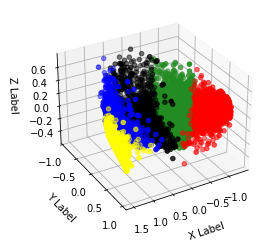

2    1275
0    1025
3    1004
1     901
4     828
dtype: int64
   NumFea  NumWin  NumEnhan    s        C     Error        ME
0       2       3         5  0.1  0.00001  0.468946  0.833689
1       2       3         5  0.1  0.00100  0.494266  0.837319
2       2       3         5  0.1  0.10000  0.488402  0.836223
3       2       3        15  0.1  0.00001  0.549436  0.847718
4       2       3        15  0.1  0.00100  0.533624  0.844154


In [191]:
short_day = 5
Triple_up = 1.03
Triple_down = 0.975
short_cluster, short_label ,short_out , short_value, short_BLS= get_CNN_cluster(8, TAIEX_df, Triple_up, Triple_down, short_day , 5 , True, [], False,0.55)

 0    1076
-1    1012
 1     998
dtype: int64
Train loss, acc: [1.3503894805908203, 0.473104327917099]
Test loss, acc : [1.420833945274353, 0.3913513422012329]
Train loss, acc: [1.3433904647827148, 0.46143874526023865]
Test loss, acc : [1.4086565971374512, 0.3837837874889374]
Train loss, acc: [1.38224196434021, 0.4368114173412323]
Test loss, acc : [1.4322924613952637, 0.3729729652404785]
Train loss, acc: [1.3888169527053833, 0.45171743631362915]
Test loss, acc : [1.407465934753418, 0.41513514518737793]
Train loss, acc: [1.3486227989196777, 0.4497731626033783]
Test loss, acc : [1.394856333732605, 0.39891892671585083]
Train loss, acc: [1.272094964981079, 0.4698638916015625]
Test loss, acc : [1.3176120519638062, 0.39243242144584656]
Train loss, acc: [1.3580045700073242, 0.46467918157577515]
Test loss, acc : [1.3982614278793335, 0.4010810852050781]
Train loss, acc: [1.372356653213501, 0.4594945013523102]
Test loss, acc : [1.395471215248108, 0.4097297191619873]
Train loss, acc: [1.337255835

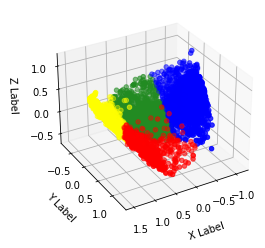

3    1800
2    1436
1    1128
0     669
dtype: int64
   NumFea  NumWin  NumEnhan    s        C     Error        ME
0       2       3         5  0.1  0.00001  0.412272  0.736159
1       2       3         5  0.1  0.00100  0.408190  0.736701
2       2       3         5  0.1  0.10000  0.407344  0.736738
3       2       3        15  0.1  0.00001  0.479675  0.751006
4       2       3        15  0.1  0.00100  0.460926  0.747983


In [192]:
long_cluster , long_label, long_out, long_value, long_BLS = get_CNN_cluster(8, TAIEX_df, (Triple_up*2-1), (Triple_down*2-1), short_day*2, 4 , True, [], False,0.55)

In [157]:
bias = False
if bias : 
    allBiasData = pd.read_csv(path+'Windows5_test.csv')
    TAIEX_bias_df = allBiasData[allBiasData.STOCK_ID == stock_list[index]]
    TAIEX_bias_df = TAIEX_bias_df[TAIEX_bias_df.Date >= TAIEX_df.Date.min()]
    TAIEX_bias_df = TAIEX_bias_df[TAIEX_bias_df.Date <= TAIEX_df.Date.max()].reset_index(drop=True)

    # df = TAIEX_bias_df[::-1].reset_index(drop=True)
    # dropLabel = ['Volume','Dividends','Stock Splits','STOCK_ID','Date']
    # price_df = df.drop(dropLabel,axis=1)

    long_bias_cluster , long_bias_label = get_CNN_cluster(20, TAIEX_df, 1.05, 0.97, 10, 4 , False, TAIEX_bias_df, True)
    short_bias_cluster, short_bias_label = get_CNN_cluster(8, TAIEX_df, 1.03, 0.98, 5 , 6 , False, TAIEX_bias_df, True)

In [158]:

short_cluster = short_cluster[:len(long_cluster)]
short_out = short_out[:len(long_cluster)]
if bias: 
    short_bias_cluster = short_bias_cluster[:len(long_cluster)]
  

In [159]:
Y = pd.DataFrame()
Y['long'] = long_label.reset_index(drop = True)
Y['short'] = short_label[:len(long_label)]

X = TAIEX_Index[::-1].reset_index(drop=True)[:len(short_cluster)]
X['date'] = X.Date
X = X.drop(['Open','High','Low','Close','STOCK_ID','Date','MA1','MA5', 'MA10',  'MA20','MA60', 'MA120',
            'MACD_signal','MACD','MACD hist','K', 'D' ,'date','Volume'],axis = 1)
#'pre5p0.1','pre5d0.1','pre3p0.05','pre3d0.05','pre1p0.03','pre1d0.03''開盤價', '最高價', '最低價', '收盤價', '成交股數', '證券代號',  '年前高', '季前高', '漲跌',
#        '均漲天數', '均跌天數','MA60', 'RSI', 'MACD_signal','MACD','MA5', 'MA10',  'MA20', 'buy5', 'buy10',  'K', 'D',
#         '實紅棒', '紅棒天線', '實黑棒', '黑棒天線', '上避雷針', '下避雷針', '連漲跌',
#        'MACD_histogram', '日振幅', '波動率', 'MA交叉型態', 'KD交叉型態', 'KD交叉型態2',
#        'MA5 slope', 'MA10 slope', 'MA60 slope', 'buy5 slope', 'buy10 slope',
#        'MA5 acc', 'RSI5鈍化', 'D5', 'D60', 'D_upper_day', 'UD5', 'UD60',
#        'UD前高壓力', 'UD波段壓立', '均線糾結1', '均線糾結2', '三陽開泰', '突破前高', '超漲跌','MACD_histogram', '日振幅', '波動率'
# 'MA_cross_5_10','MA_cross_5_20','MA_cross_5_60','MA_cross_10_60','MA_cross_10_20','MA_cross_20_60','MA_cross_5_120'
# # adding cluster
# X['long_cluster'] = long_cluster
# X['short_cluster'] = short_cluster

if bias:
    X['long_bias_cluster'] = long_bias_cluster
    X['short_bias_cluster'] = short_bias_cluster

Y = Y[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]

#TAIEX_Index = allData[allData.STOCK_ID == stock_list[index]].reset_index(drop=True)[10:].reset_index(drop=True)

In [160]:
X.columns

Index(['MA_cross_1_5', 'MA_cross_1_60', 'MA_cross_5_10', 'MA_cross_5_20',
       'MA_cross_5_60', 'MA_cross_5_120', 'MA_cross_10_20', 'MA_cross_10_60',
       'MA_cross_20_60', 'MACD_cross_6', 'overBuyOrSold(80/20)_6', 'cross_6',
       'over_3days_6', 'MACD_cross_9', 'overBuyOrSold(80/20)_9', 'cross_9',
       'over_3days_9', 'MACD_cross_12', 'overBuyOrSold(80/20)_12', 'cross_12',
       'over_3days_12'],
      dtype='object')

In [161]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
data_whole_ohe= pd.DataFrame(onehotencoder.fit_transform(X).toarray())
print(data_whole_ohe)

       0    1    2    3    4    5    6    7    8    9   ...   71   72   73  \
0     0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  1.0   
1     0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  1.0   
2     0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  1.0   
3     0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  1.0   
4     0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
5028  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  1.0   
5029  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  1.0   
5030  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  1.0   
5031  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  1.0   
5032  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  1.0   

       74   75   76   77   78   79   80  
0     0.0  0.0  1.0  

In [162]:
zero_term = data_whole_ohe.describe().loc['mean'][data_whole_ohe.describe().loc['mean']>0.5].index

In [163]:
data_whole_ohe = data_whole_ohe.drop(zero_term, axis = 1)

In [164]:
cross_feature(data_whole_ohe)

C:\Users\kevin\AppData\Local\Temp/ipykernel_14944/3974235746.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X_catagory[name] = X_catagory[i]*X_catagory[j]


In [165]:
## 對 binary data 取 embedding
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(len(data_whole_ohe.columns), 3, input_length=len(data_whole_ohe.columns)))
model.add(Flatten())
model.add(Dense(80))
model.add(Dense(3))
model.compile('rmsprop', 'acc')

In [166]:
## 將binary資料做embedding，減少訓練的複雜度
X_embedding = model.predict(data_whole_ohe.values)

In [167]:
X_embedding

array([[ 0.02134733, -0.03134327,  0.00548445],
       [ 0.0213949 , -0.0300855 ,  0.00578537],
       [ 0.0246094 , -0.02478419, -0.00666888],
       ...,
       [ 0.01523186, -0.03478472,  0.00370511],
       [ 0.01916652, -0.03220536,  0.0030109 ],
       [ 0.0217122 , -0.02895157,  0.0045451 ]], dtype=float32)

In [168]:
X

,MA_cross_1_5,MA_cross_1_60,MA_cross_5_10,MA_cross_5_20,MA_cross_5_60,MA_cross_5_120,MA_cross_10_20,MA_cross_10_60,MA_cross_20_60,MACD_cross_6,...,cross_6,over_3days_6,MACD_cross_9,overBuyOrSold(80/20)_9,cross_9,over_3days_9,MACD_cross_12,overBuyOrSold(80/20)_12,cross_12,over_3days_12
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,...,0,0,-1,0,0,0,-1,0,0,0
3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
5029,1.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0,...,1,0,0,0,1,0,0,0,1,0
5030,-0.5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
5031,-1.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,-1,0


In [169]:
X['short'] = Y.short
X['long'] = Y.long

In [170]:
column_, value_ , number_ , rise_, drop_, rise_drop_ , long_rise_, long_drop_, long_rise_drop_= ([] for i in range(9))
for c in X.columns :
    value = pd.Series(X[c], dtype="category").cat.categories.tolist()
    for v in value : 
        temp = X[X[c] == v]
        column_.append(c)
        value_.append(v)
        number_.append(len(temp)/len(X))
        rise_.append(sum(temp.short == 1)/len(temp))        
        drop_.append(sum(temp.short == -1)/len(temp))
        rise_drop_.append(sum(temp.short == 1)/(sum(temp.short == -1)+1))

        long_rise_.append(sum(temp.long == 1)/len(temp))
        long_drop_.append(sum(temp.long == -1)/len(temp))
        long_rise_drop_.append(sum(temp.long == 1)/(sum(temp.long == -1)+1))
        

In [171]:
show_ = pd.DataFrame(list(zip(column_, value_ , number_ , rise_, drop_, rise_drop_ , long_rise_, long_drop_, long_rise_drop_))
                     , columns=['indicator', 'value' , 'number', 'rise', 'drop', 'rise_drop' , 'long_rise', 'long_drop', 'long_rise_drop'])

In [172]:
show_ =show_.sort_values(by=['rise_drop'], ascending=False).reset_index(drop=True)
show_[:]

,indicator,value,number,rise,drop,rise_drop,long_rise,long_drop,long_rise_drop
0,short,1.0,0.372939,1.000000,0.000000,1877.000000,0.636654,0.080980,7.810458
1,long,1.0,0.307967,0.770968,0.096129,7.966667,1.000000,0.000000,1550.000000
2,MA_cross_20_60,0.5,0.008941,0.444444,0.288889,1.428571,0.422222,0.222222,1.727273
3,over_3days_6,-1.0,0.043314,0.486239,0.348624,1.376623,0.385321,0.399083,0.954545
4,over_3days_9,-1.0,0.060203,0.465347,0.353135,1.305556,0.339934,0.376238,0.895652
...,...,...,...,...,...,...,...,...,...
82,MA_cross_5_120,0.5,0.008941,0.244444,0.488889,0.478261,0.222222,0.400000,0.526316
83,MA_cross_10_60,-1.0,0.011127,0.214286,0.464286,0.444444,0.196429,0.410714,0.458333
84,long,-1.0,0.323068,0.093481,0.791513,0.118012,0.000000,1.000000,0.000000
85,short,-1.0,0.383469,0.000000,1.000000,0.000000,0.077202,0.666839,0.115683


In [173]:
sog_rise = []
sog_drop = []
rise_threshold = X.short.value_counts()[1]/X.short.value_counts()[-1]*1.05
drop_threshold = X.short.value_counts()[1]/X.short.value_counts()[-1]*0.95

high = show_[show_.rise_drop >= rise_threshold].reset_index(drop=True)
low =  show_[show_.rise_drop <= drop_threshold].reset_index(drop=True)
for i in X.index :
    score = 0
    for h in high.index :
        if high.iloc[h].indicator in 'short_cluster' or high.iloc[h].indicator in 'long_cluster' :
            continue
        if X.iloc[i][high.iloc[h].indicator] == high.iloc[h].value :
            score += high.iloc[h].rise_drop**2
    sog_rise.append(score)
    
    score = 0
    for h in low.index :
        if low.iloc[h].indicator in 'short_cluster' or low.iloc[h].indicator in 'long_cluster' :
            continue
        if X.iloc[i][low.iloc[h].indicator] == low.iloc[h].value :
            score += (1/low.iloc[h].rise_drop)**2
    sog_drop.append(score)

In [174]:
def print_out(df):
    try : 
        print('get_ratio : {}, rise :{} , drop:{}, rise_drop :{}'.format(len(df)/len(X), df.short.value_counts()[1]/len(df),df.short.value_counts()[-1]/len(df),df.short.value_counts()[1]/(df.short.value_counts()[-1])))
    except :
        print()

In [175]:
for i in range(10): 
    print ('score over ', i)
    print_out(X[pd.Series(sog_rise) > i])

print("----------------------------------------")
for i in range(10): 
    print ('score over ', i)
    print_out(X[pd.Series(sog_drop) > i])

score over  0
get_ratio : 0.5189747665408305, rise :0.39739663093415006 , drop:0.35872894333843797, rise_drop :1.1077908217716115
score over  1
get_ratio : 0.5189747665408305, rise :0.39739663093415006 , drop:0.35872894333843797, rise_drop :1.1077908217716115
score over  2
get_ratio : 0.319292668388635, rise :0.3982576228998133 , drop:0.3634100808960797, rise_drop :1.095890410958904
score over  3
get_ratio : 0.19809258891317305, rise :0.41223671013039115 , drop:0.3530591775325978, rise_drop :1.1676136363636365
score over  4
get_ratio : 0.12378303198887343, rise :0.4317817014446228 , drop:0.34831460674157305, rise_drop :1.23963133640553
score over  5
get_ratio : 0.0858334989072124, rise :0.42592592592592593 , drop:0.3541666666666667, rise_drop :1.2026143790849673
score over  6
get_ratio : 0.06079872839260878, rise :0.46405228758169936 , drop:0.34967320261437906, rise_drop :1.3271028037383177
score over  7
get_ratio : 0.04828134313530697, rise :0.4773662551440329 , drop:0.366255144032921

In [176]:
show_ =show_.sort_values(by=['long_rise_drop'], ascending=False).reset_index(drop=True)
show_[:]

,indicator,value,number,rise,drop,rise_drop,long_rise,long_drop,long_rise_drop
0,long,1.0,0.307967,0.770968,0.096129,7.966667,1.000000,0.000000,1550.000000
1,short,1.0,0.372939,1.000000,0.000000,1877.000000,0.636654,0.080980,7.810458
2,MA_cross_20_60,0.5,0.008941,0.444444,0.288889,1.428571,0.422222,0.222222,1.727273
3,over_3days_12,1.0,0.095371,0.347917,0.400000,0.865285,0.391667,0.245833,1.579832
4,over_3days_9,1.0,0.070534,0.315493,0.408451,0.767123,0.380282,0.259155,1.451613
...,...,...,...,...,...,...,...,...,...
82,MA_cross_5_120,-1.0,0.009140,0.391304,0.347826,1.058824,0.195652,0.434783,0.428571
83,MA_cross_5_120,-0.5,0.009140,0.347826,0.326087,1.000000,0.195652,0.500000,0.375000
84,short,-1.0,0.383469,0.000000,1.000000,0.000000,0.077202,0.666839,0.115683
85,long,0.0,0.368965,0.285407,0.266020,1.070707,0.000000,0.000000,0.000000


In [177]:
long_sog_rise = []
long_sog_drop = []
rise_threshold = X.long.value_counts()[1]/X.long.value_counts()[-1]*1.05
drop_threshold = X.long.value_counts()[1]/X.long.value_counts()[-1]*0.95

high = show_[show_.long_rise_drop >= rise_threshold].reset_index(drop=True)
low =  show_[show_.long_rise_drop <= drop_threshold].reset_index(drop=True)
for i in X.index :
    score = 0
    for h in high.index :
        if high.iloc[h].indicator in 'short_cluster' or high.iloc[h].indicator in 'long_cluster' :
            continue
        if X.iloc[i][high.iloc[h].indicator] == high.iloc[h].value :
            score += high.iloc[h].long_rise_drop**2
    long_sog_rise.append(score)
    
    score = 0
    for h in low.index :
        if low.iloc[h].indicator in 'short_cluster' or low.iloc[h].indicator in 'long_cluster' :
            continue
        if X.iloc[i][low.iloc[h].indicator] == low.iloc[h].value :
            score += (1/low.iloc[h].long_rise_drop)**2
    long_sog_drop.append(score)

In [178]:
for i in range(10): 
    print ('score over ', i)
    print_out(X[pd.Series(long_sog_rise) > i])

print("----------------------------------------")
for i in range(10): 
    print ('score over ', i)
    print_out(X[pd.Series(long_sog_drop) > i])

score over  0
get_ratio : 0.6485197695211603, rise :0.36672794117647056 , drop:0.38296568627450983, rise_drop :0.9576
score over  1
get_ratio : 0.6485197695211603, rise :0.36672794117647056 , drop:0.38296568627450983, rise_drop :0.9576
score over  2
get_ratio : 0.29703953904232067, rise :0.35785953177257523 , drop:0.4040133779264214, rise_drop :0.8857615894039735
score over  3
get_ratio : 0.19451619312537255, rise :0.36363636363636365 , drop:0.4024514811031665, rise_drop :0.9035532994923858
score over  4
get_ratio : 0.13570435128154182, rise :0.35871156661786235 , drop:0.3967789165446559, rise_drop :0.9040590405904059
score over  5
get_ratio : 0.10649711901450427, rise :0.33955223880597013 , drop:0.4048507462686567, rise_drop :0.8387096774193549
score over  6
get_ratio : 0.08404530101331215, rise :0.33569739952718675 , drop:0.40425531914893614, rise_drop :0.8304093567251462
score over  7
get_ratio : 0.07311742499503278, rise :0.32608695652173914 , drop:0.4076086956521739, rise_drop :0.

predict_test = pd.DataFrame(list(zip(X[X.sog_rise > 7].date, np.ones(len(X[X.sog_rise > 7].date)),np.ones(len(X[X.sog_rise > 7].date)))
                                ),columns = ['date','long','short'])


In [362]:
# read index
# allIndex = pd.read_csv(path+'D2_model.csv')
# TAIEX_Index = allIndex[allIndex.STOCK_ID == stock_list[index]].reset_index(drop=True)[10:].reset_index(drop=True)

Y = pd.DataFrame()
Y['long'] = long_label.reset_index(drop = True)
Y['short'] = short_label[:len(long_label)]

X = TAIEX_Index[::-1].reset_index(drop=True)[:len(short_cluster)]
X['date'] = X.Date
X = X.drop(['Open','High','Low','Close','STOCK_ID','Date','MA1','MA5', 'MA10',  'MA20','MA60', 'MA120',
            'MACD_signal','MACD','MACD hist','K', 'D' ,'MA_cross_1_5', 'MA_cross_1_60', 'MA_cross_5_10',
       'MA_cross_5_20', 'MA_cross_5_60', 'MA_cross_5_120', 'MA_cross_10_20',
       'MA_cross_10_60', 'MA_cross_20_60', 'MACD_cross_6',
       'overBuyOrSold(80/20)_6', 'cross_6', 'over_3days_6', 'MACD_cross_9',
       'overBuyOrSold(80/20)_9', 'cross_9', 'over_3days_9', 'MACD_cross_12',
       'overBuyOrSold(80/20)_12', 'cross_12', 'over_3days_12',],axis = 1)
#'pre5p0.1','pre5d0.1','pre3p0.05','pre3d0.05','pre1p0.03','pre1d0.03''開盤價', '最高價', '最低價', '收盤價', '成交股數', '證券代號',  '年前高', '季前高', '漲跌',
#        '均漲天數', '均跌天數','MA60', 'RSI', 'MACD_signal','MACD','MA5', 'MA10',  'MA20', 'buy5', 'buy10',  'K', 'D',
#         '實紅棒', '紅棒天線', '實黑棒', '黑棒天線', '上避雷針', '下避雷針', '連漲跌',
#        'MACD_histogram', '日振幅', '波動率', 'MA交叉型態', 'KD交叉型態', 'KD交叉型態2',
#        'MA5 slope', 'MA10 slope', 'MA60 slope', 'buy5 slope', 'buy10 slope',
#        'MA5 acc', 'RSI5鈍化', 'D5', 'D60', 'D_upper_day', 'UD5', 'UD60',
#        'UD前高壓力', 'UD波段壓立', '均線糾結1', '均線糾結2', '三陽開泰', '突破前高', '超漲跌','MACD_histogram', '日振幅', '波動率'
# 'MA_cross_5_10','MA_cross_5_20','MA_cross_5_60','MA_cross_10_60','MA_cross_10_20','MA_cross_20_60','MA_cross_5_120'
# adding cluster
X['long_cluster'] = long_cluster
X['short_cluster'] = short_cluster

# X['long_bias_cluster'] = long_bias_cluster
# X['short_bias_cluster'] = short_bias_cluster

if bias:
    X['long_bias_cluster'] = long_bias_cluster
    X['short_bias_cluster'] = short_bias_cluster

Y = Y[~X.isin([np.nan, np.inf, -np.inf]).any(1)]
X = X[~X.isin([np.nan, np.inf, -np.inf]).any(1)]

#TAIEX_Index = allData[allData.STOCK_ID == stock_list[index]].reset_index(drop=True)[10:].reset_index(drop=True)

In [363]:
X.columns

Index(['Volume', 'date', 'long_cluster', 'short_cluster'], dtype='object')

In [364]:
onehotencoder = OneHotEncoder()
data_whole_ohe= pd.DataFrame(onehotencoder.fit_transform(X.drop(['Volume', 'date'], axis = 1)).toarray())
print(data_whole_ohe)

        0    1    2    3    4    5    6    7    8
0     0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
1     0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
2     0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
3     0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
4     0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...
5028  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0
5029  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0
5030  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
5031  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
5032  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0

[5033 rows x 9 columns]


In [365]:
data_whole_ohe['date']= X.date

In [366]:
X = data_whole_ohe

In [367]:
# X['short_0'] = short_cluster.T[0]
# X['short_1'] = short_cluster.T[1]
# X['short_2'] = short_cluster.T[2]
# X['short_3'] = short_cluster.T[3]
# X['short_4'] = short_cluster.T[4]

# X['long_0'] = long_cluster.T[0]
# X['long_1'] = long_cluster.T[1]
# X['long_2'] = long_cluster.T[2]
# X['long_3'] = long_cluster.T[3]
# pd.crosstab((X['short_2']*10).apply(np.ceil), Y['short']).plot(kind='bar', stacked = True, title = "EB0")

In [368]:
X['long_out'] = long_out
X['short_out'] = short_out
X['long_BLS'] = long_BLS
X['short_BLS'] = short_BLS
X['embedding_0'] = X_embedding.T[0]
X['embedding_1'] = X_embedding.T[1]
X['embedding_2'] = X_embedding.T[2]

In [369]:
X['sog_rise'] = sog_rise
X['sog_drop'] = sog_drop
X['long_sog_rise'] = long_sog_rise
X['long_sog_drop'] = long_sog_drop

In [370]:
# X['short_cluster'] = short_cluster

In [371]:
X

,0,1,2,3,4,5,6,7,8,date,...,short_out,long_BLS,short_BLS,embedding_0,embedding_1,embedding_2,sog_rise,sog_drop,long_sog_rise,long_sog_drop
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20220111,...,1,-0.078028,0.081567,0.021347,-0.031343,0.005484,0.000000,1.179068,0.000000,2.549901
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20220110,...,1,-0.063200,0.082489,0.021395,-0.030086,0.005785,1.246583,1.179068,1.021163,2.549901
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20220107,...,1,-0.033797,0.100084,0.024609,-0.024784,-0.006669,1.435251,1.179068,3.168981,2.549901
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20220106,...,1,-0.001543,0.064974,0.023764,-0.033249,0.006304,1.143870,0.000000,1.134087,1.224160
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,20220105,...,1,0.060191,0.014199,0.022028,-0.034138,0.005296,1.321178,0.000000,1.074975,1.224160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,20010821,...,2,-0.005083,-0.058598,0.026465,-0.034415,0.006521,1.143870,1.253426,1.134087,3.027425
5029,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,20010820,...,2,-0.019364,-0.052093,0.029071,-0.035028,0.002892,4.886474,1.759683,1.074975,4.384795
5030,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20010817,...,1,-0.028068,0.006601,0.015232,-0.034785,0.003705,0.000000,2.728124,1.263961,4.142551
5031,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20010816,...,1,-0.024660,0.034432,0.019167,-0.032205,0.003011,1.246583,1.391190,3.283727,1.224160


In [372]:
Y.short.value_counts()

-1    1930
 1    1877
 0    1226
Name: short, dtype: int64

Y[X['short_cluster']<0].short.value_counts()

pd.crosstab((X['short_cluster']*3).apply(np.ceil), (Y['short'] == 1)/len(Y['short'])).plot(kind='bar', stacked = True, title = "EB0")

pd.crosstab((X['short_cluster']*3).apply(np.ceil), Y['short']).plot(kind='bar', stacked = True, title = "EB0")

pd.crosstab((X['embedding_2']*1000).apply(np.ceil), Y['short']).plot(kind='bar', stacked = True, title = "EB0")

Y = Y[X.sog_drop <= 1].reset_index(drop=True)
X = X[X.sog_drop <= 1].reset_index(drop=True)

In [373]:
Y.long.value_counts()

 0    1857
-1    1626
 1    1550
Name: long, dtype: int64

In [374]:
Y.short.value_counts()

-1    1930
 1    1877
 0    1226
Name: short, dtype: int64

## training feature : train with all feature
- serveal index and time serises price data
---
## XGBoost

In [375]:
from matplotlib import pyplot as plt
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()


In [376]:
Y[:math.ceil(len(Y)*0.3)].short.value_counts()

 1    545
-1    513
 0    452
Name: short, dtype: int64

In [377]:
Y[math.ceil(len(Y)*0.3):].short.value_counts()

-1    1417
 1    1332
 0     774
Name: short, dtype: int64

In [378]:
Y.short.value_counts()

-1    1930
 1    1877
 0    1226
Name: short, dtype: int64

In [379]:
keep_ratio = 0.5
Y = Y[:math.ceil(len(X)*keep_ratio)].reset_index(drop = True)
X = X [:math.ceil(len(X)*keep_ratio)].reset_index(drop = True)

In [380]:
X[:math.ceil(len(X)*keep_ratio)].reset_index(drop = True)

,0,1,2,3,4,5,6,7,8,date,...,short_out,long_BLS,short_BLS,embedding_0,embedding_1,embedding_2,sog_rise,sog_drop,long_sog_rise,long_sog_drop
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20220111,...,1,-0.078028,0.081567,0.021347,-0.031343,0.005484,0.000000,1.179068,0.000000,2.549901
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20220110,...,1,-0.063200,0.082489,0.021395,-0.030086,0.005785,1.246583,1.179068,1.021163,2.549901
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20220107,...,1,-0.033797,0.100084,0.024609,-0.024784,-0.006669,1.435251,1.179068,3.168981,2.549901
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,20220106,...,1,-0.001543,0.064974,0.023764,-0.033249,0.006304,1.143870,0.000000,1.134087,1.224160
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,20220105,...,1,0.060191,0.014199,0.022028,-0.034138,0.005296,1.321178,0.000000,1.074975,1.224160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,20161118,...,2,-0.026139,-0.082538,0.023764,-0.033249,0.006304,1.143870,0.000000,1.134087,1.224160
1255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20161117,...,2,-0.026654,-0.032103,0.022028,-0.034138,0.005296,1.321178,0.000000,1.074975,1.224160
1256,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20161116,...,2,-0.056256,0.032880,0.022666,-0.033715,0.003067,2.632637,1.179068,0.000000,4.063697
1257,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20161115,...,1,-0.063186,0.054826,0.022666,-0.033715,0.003067,2.632637,1.179068,0.000000,4.063697


label :  long
test date start form  20220111 to 20171124


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training score : 0.8433945756780402
precision(-1, 0, 1: [0.85909713 0.80194411 0.87431694]
recall score(-1, 0, 1: [0.82414698 0.86614173 0.83989501]
testing score : 0.4001986097318769
precision(-1, 0, 1: [0.31386861 0.41996234 0.46534653]
recall score(-1, 0, 1: [0.33463035 0.55334988 0.27089337]


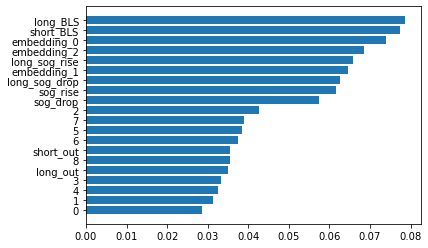

label :  short
test date start form  20220111 to 20171124


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


training score : 0.8132075471698114
precision(-1, 0, 1: [0.80855019 0.82970297 0.80255941]
recall score(-1, 0, 1: [0.82075472 0.79056604 0.82830189]
testing score : 0.35948361469712015
precision(-1, 0, 1: [0.36342593 0.26785714 0.44067797]
recall score(-1, 0, 1: [0.43854749 0.3        0.32581454]


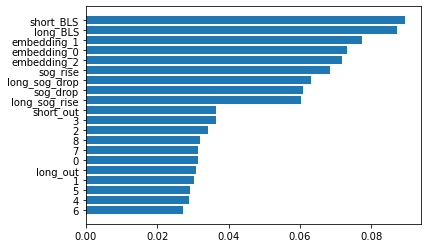

In [381]:
from sklearn.metrics import precision_recall_fscore_support as score
label_ = ['long' , 'short']
predict_ = pd.DataFrame()
predict_test = pd.DataFrame()
isFirst = True

test_ratio = 0.4
# X = X[: math.ceil(len(X)*test_ratio)].reset_index(drop = True)
# Y = Y[: math.ceil(len(Y)*test_ratio)].reset_index(drop = True)
    
for label in label_ :
    trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
    testp = X [ : math.ceil(len(X)*test_ratio)]
    print("label : ", label )
    print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

#     X_train = trainp.drop(['date','Volume'],axis = 1)
    
    X_train = trainp.drop(['date'],axis = 1)
    y_train = Y[label][math.ceil(len(X)*test_ratio) :]

    X_test = testp.drop(['date'],axis = 1)
    y_test = Y[label] [ : math.ceil(len(X)*test_ratio)]

    X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
#     ros = RandomOverSampler(random_state = 40)
#     X_train, y_train = ros.fit_resample(X_train, y_train)

    model = XGBClassifier( booster='gbtree', max_depth=3, subsample = 0.5, 
                colsample_bytree=0.5, colsample_bylevel=0.5, colsample_bynode=0.5,
                  n_estimators=300, n_jobs=4, nthread=-1, eval_metric='mlogloss',
                  random_state=27,  tree_method='exact',
                  validate_parameters=1, verbosity=None)
    
    model.fit(X_train,y_train)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    print('training score :' , accuracy_score(y_train, y_train_pred))
    precision, recall, f1, _ = score(y_train, y_train_pred)
    print ( "precision(-1, 0, 1:" ,precision )    
    print ( "recall score(-1, 0, 1:" ,recall )
    print('testing score :' , accuracy_score( y_test_pred,y_test))
    precision, recall, f1, _ = score(y_test, y_test_pred)
    
    print ( "precision(-1, 0, 1:" ,precision )    
    print ( "recall score(-1, 0, 1:" ,recall )
    
    # feature important plot
    f_importances(model.feature_importances_, X_train.columns)

    if isFirst :
        isFirst = False       
#         predict_['date'] = trainp.date
        predict_test['date'] = testp.date

#     predict_[label] = y_train_pred
    predict_test[label] = y_test_pred

In [382]:
pd.Series(y_train_pred).value_counts()

 1    547
-1    538
 0    505
dtype: int64

In [383]:
pd.Series(y_test_pred).value_counts()

-1    432
 1    295
 0    280
dtype: int64

In [384]:
predict_test

,date,long,short
0,20220111,0,0
1,20220110,-1,-1
2,20220107,0,-1
3,20220106,0,1
4,20220105,1,-1
...,...,...,...
1002,20171130,0,0
1003,20171129,1,0
1004,20171128,-1,-1
1005,20171127,-1,-1


In [385]:
xgb_test = y_test_pred

---
## RF

In [410]:
label_ = ['long' , 'short']
cluster = [0,1,2]

isFirst = True
for label in label_ :
    trainp = X [math.ceil(len(X)*test_ratio) :].reset_index(drop = True)
    testp = X [ : math.ceil(len(X)*test_ratio)]
    print("label : ", label )
    print("test date start form ", testp.date[0],"to", testp.date[len(testp)-1] )

    X_train = trainp.drop(['date'],axis = 1)
    y_train = Y[label][math.ceil(len(X)*test_ratio) :]

    X_test = testp.drop(['date'],axis = 1)
    y_test = Y[label] [ : math.ceil(len(X)*test_ratio)]

    X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
#     ros = RandomOverSampler(random_state = 40)
#     X_train, y_train = ros.fit_resample(X_train, y_train)

    #clf=svm.SVC(kernel='rbf')
    model = RandomForestClassifier(n_estimators=200, max_depth=8,random_state=42,max_samples = 0.3)
    
    model.fit(X_train,y_train)
    if label == 'long' : 
        y_test_pred_long = model.predict(X_test)    
    y_test_pred = model.predict(X_test)

    y_train_pred = model.predict(X_train)
    precision, recall, f1, _ = score(y_test, y_test_pred)
    print ( "precision(-1, 0, 1:" ,precision )    
    print ( "recall score(-1, 0, 1:" ,recall )
    Y_train_pre = model.predict(X_train)
    print('training score :' , accuracy_score(y_train, Y_train_pre))
    print('testing score :' , accuracy_score(y_test, y_test_pred))
    
    
for i in range(len(predict_test)):
    if predict_test.short[i] != y_test_pred[i]*-1 :
        continue
    else :
        predict_test.short[i]= 0

for i in range(len(predict_test)):
    if predict_test.long[i] != y_test_pred_long[i]*-1 :
        continue
    else :
        predict_test.long[i]= 0     
        
precision, recall, f1, _ = score(y_test, predict_test.short)
print ( "precision(-1, 0, 1):" ,precision )
print ( "recall score(-1, 0, 1):" ,recall )


label :  long
test date start form  20220111 to 20171124


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kevin\anaconda3\lib

precision(-1, 0, 1: [0.3255814  0.4174397  0.45714286]
recall score(-1, 0, 1: [0.32684825 0.55831266 0.27665706]
training score : 0.7392825896762905
testing score : 0.40218470705064546
label :  short
test date start form  20220111 to 20171124


C:\Users\kevin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kevin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kevin\anaconda3\lib

precision(-1, 0, 1: [0.4056338  0.25679758 0.46417445]
recall score(-1, 0, 1: [0.40223464 0.34       0.37343358]
training score : 0.7163522012578616
testing score : 0.3753723932472691
precision(-1, 0, 1): [0.39642857 0.25585938 0.44186047]
recall score(-1, 0, 1): [0.31005587 0.524      0.23809524]


In [411]:
predict_test

,date,long,short
0,20220111,0,0
1,20220110,-1,0
2,20220107,0,0
3,20220106,0,1
4,20220105,1,0
...,...,...,...
1002,20171130,0,0
1003,20171129,1,0
1004,20171128,-1,-1
1005,20171127,-1,-1


In [412]:
# optimize by train
selected = predict_[::-1].reset_index(drop=True)
selected = selected [math.ceil(len(selected)*3/4):].reset_index(drop=True)

In [450]:
# optimize by test
selected = predict_test[::-1].reset_index(drop=True)
# selected = selected [:len(selected)-10].reset_index(drop=True)
selected = selected [:math.ceil(len(selected)/3)].reset_index(drop=True)

In [425]:
selected

,date,long,short
0,20171124,0,1
1,20171127,-1,-1
2,20171128,-1,-1
3,20171129,1,0
4,20171130,0,0
...,...,...,...
992,20211221,0,0
993,20211222,1,1
994,20211223,0,-1
995,20211224,-1,-1


In [437]:
days = [1,6,8,11,15]

table = pd.DataFrame()
p_table = []
l_table = []
d_table = []
average = []

for d in days :
    d = d-1
    if (d==0):
        profit = [0.02,0.025,0.03,0.035,0.04,0.045,0.05,0.06,0.07,0.08,0.095] 
        loss = [0.01,0.015,0.02,0.025,0.035,0.045,0.055]
        fee = 0.0015+0.0029*0.3
    else :
        profit = [0.075,0.1,0.125,0.15,0.2] 
        loss = [0.075,0.1,0.15]
        fee = 0.003+0.0029*0.3
    
    for p in profit : 
        停利 = p
        for l in loss :
            停損 = l * -1

            進場日期 = []
            出場日期 = []
            進場價格 = []
            出場價格 = []
            獲利 = []
            for i in range(len(selected)):
                if selected.short[i] > 0 and selected.long[i] > 0 :  
                    temp = TAIEX_Index [TAIEX_Index.Date > selected.date[i]].reset_index(drop = True)
                    if len(出場日期)>0 and selected.date[i] < 出場日期[-1] : 
                        continue
                    price = temp.Open[0]
                    進場價格.append(price)
                    進場日期.append(temp.Date[0])
                    for j in range(len(temp)):
                        if temp.High[j] > price *(1.00+停利) :
                            出場價格.append(price *(1+停利-fee))
                            出場日期.append(temp.Date[j])
                            break  
                        elif temp.Low[j] < price *(1 + 停損):
                            出場價格.append(price *(1+停損-fee))
                            出場日期.append(temp.Date[j])
                            break
                        elif j > d :
                            出場價格.append(temp.Close[j]*(1-fee))
                            出場日期.append(temp.Date[j])
                            break
                        elif j >= len(temp)-1:
                            出場價格.append(temp.Close[j]*(1-fee))
                            出場日期.append(temp.Date[j])
                    獲利.append((出場價格[-1]/進場價格[-1])-1)
                    
            績效表 = pd.DataFrame()
            績效表['進場日期'] = 進場日期
            績效表['出場日期'] = 出場日期
            績效表['進場價格'] = 進場價格
            績效表['出場價格'] = 出場價格
            績效表['獲利'] = 獲利
            
            p_table.append(p)
            l_table.append(l)
            d_table.append(d)
            average.append(sum(績效表.獲利) / (len(績效表)*((d+1))))
            
table['p'] = p_table
table['l'] = l_table
table['d'] = d_table
table['a'] = average

In [438]:
table = table.sort_values(by=['a'],ascending=False).reset_index(drop = True)
day_trade = table[table.d == 0].reset_index(drop=True)
day_trade

,p,l,d,a
0,0.095,0.010,0,0.004229
1,0.080,0.010,0,0.003831
2,0.070,0.035,0,0.003810
3,0.095,0.035,0,0.003808
4,0.060,0.035,0,0.003803
...,...,...,...,...
72,0.040,0.055,0,-0.000570
73,0.030,0.045,0,-0.000653
74,0.020,0.045,0,-0.001113
75,0.030,0.055,0,-0.001120


In [439]:
swing = table[table.d > 0].reset_index(drop=True)
swing

,p,l,d,a
0,0.200,0.075,5,0.002925
1,0.200,0.150,7,0.002794
2,0.150,0.075,5,0.002742
3,0.200,0.100,5,0.002719
4,0.200,0.150,5,0.002673
5,0.200,0.075,7,0.002590
6,0.125,0.075,5,0.002554
7,0.150,0.100,5,0.002535
8,0.100,0.075,5,0.002533
9,0.150,0.150,7,0.002528


In [440]:
selected = predict_test[::-1].reset_index(drop=True)
selected = selected [:len(selected)].reset_index(drop=True)
selected

,date,long,short
0,20171124,0,1
1,20171127,-1,-1
2,20171128,-1,-1
3,20171129,1,0
4,20171130,0,0
...,...,...,...
1002,20220105,1,0
1003,20220106,0,1
1004,20220107,0,0
1005,20220110,-1,0


import matplotlib.pyplot as plt
def plot(outcome) : 
    fig,ax=plt.subplots(figsize=(10,5))
    ax.plot(outcome.accumulate/outcome.accumulate[0],color='red',label='profit')
    ax.set_ylabel('profit',color='red',fontsize=20)
    ax.tick_params(axis='y',labelcolor='skyblue')
    plt.grid()
    ax.legend(loc='upper left')

    ax2=ax
    ax2.plot(outcome.出場價格/outcome.出場價格[0],color='black',label='Market')
    ax2.set_ylabel('Price',color='black',fontsize=20)
    ax2.tick_params(axis='y',labelcolor='black')
    ax2.legend(loc='upper right')

    plt.title('profit v.s. Closed Price ', color='black')
    plt.show()

In [441]:
import matplotlib.pyplot as plt
def plot_all(outcome, buy_index , acc_list) : 
    temp = TAIEX_Index [TAIEX_Index.Date > outcome.出場日期[0]].reset_index(drop = True)
    fig,ax=plt.subplots(figsize=(10,5))
    acc_list.append(acc_list[-1])
    ax.plot( np.array(buy_index)-buy_index[0], acc_list/outcome.出場價格[0],color='red',label='profit')
    ax.set_ylabel('profit',color='red',fontsize=20)
    ax.tick_params(axis='y',labelcolor='skyblue')
    plt.grid()
    ax.legend(loc='upper left')

    ax2=ax
    ax2.plot(temp.Close/outcome.出場價格[0],color='black',label='Market')
    ax2.set_ylabel('Price',color='black',fontsize=20)
    ax2.tick_params(axis='y',labelcolor='black')
    ax2.legend(loc='upper right')

    plt.title('profit v.s. Closed Price ', color='black')
    plt.show()

In [442]:
def estimate_return(short_shres,long_shres):
    進場日期 = []
    出場日期 = []
    進場價格 = []
    出場價格 = []
    獲利 = []
    buy_index = []
    acc_list = []
    accumulate = []
    for i in range(len(selected)-1):
        if selected.short[i] > short_shres and selected.long[i] > long_shres :
            if len(出場日期)>0 and selected.date[i] < 出場日期[-1] : 
                continue
            temp = TAIEX_Index [TAIEX_Index.Date > selected.date[i]].reset_index(drop = True)
            price = temp.Open[0]
            進場價格.append(price)
            進場日期.append(temp.Date[0])
            buy_index.append(i)
            flag = False
            for j in range(len(temp)):
                if temp.High[j] > price *(1.00+停利) :
                    出場價格.append(price *(return_+停利))
                    出場日期.append(temp.Date[j])
                    buy_index.append(i+j)
                    break  
                elif temp.Low[j] < price *(1 + 停損):
                    出場價格.append(price *(return_+停損))
                    出場日期.append(temp.Date[j])
                    buy_index.append(i+j)
                    break
                elif j >= d :
                    出場價格.append(temp.Close[j]*return_)
                    出場日期.append(temp.Date[j])
                    buy_index.append(i+j)
                    break
                elif j >= len(temp)-1:
                    出場價格.append(temp.Close[j]*return_)
                    出場日期.append(temp.Date[j])
                    buy_index.append(i+j)
                    break
            獲利.append((出場價格[-1]/進場價格[-1])-1)
            if len(accumulate) == 0 :
                acc_list.append((出場價格[-1]))
                accumulate.append((出場價格[-1]))
            else :
                if(d == 0):
                    accumulate.append(accumulate[-1] + (出場價格[-1] - 進場價格[-1])*math.ceil(2000/進場價格[-1]))
                    acc_list.append(accumulate[-1])
                    acc_list.append(accumulate[-1])
                else :
                    accumulate.append(accumulate[-1] + (出場價格[-1] - 進場價格[-1]))
                    acc_list.append(accumulate[-1])
                    acc_list.append(accumulate[-1])
    績效表 = pd.DataFrame()
    績效表['進場日期'] = 進場日期
    績效表['出場日期'] = 出場日期
    績效表['進場價格'] = 進場價格
    績效表['出場價格'] = 出場價格
    績效表['獲利'] = 獲利
    績效表['accumulate'] = accumulate

    print(績效表.獲利.std())
    print( "profit :{} , loss:{} , day :{} , out : {}, total_trade : {}".format(停利,停損, d,  sum(績效表.獲利) / len(績效表),  len(績效表)))
    plot_all(績效表,buy_index , acc_list)
    time_ratio = len(績效表.獲利)*(d) / len(selected)
    retun_ratio = (績效表.accumulate[len(績效表.獲利)-1]-績效表.進場價格[0])/(績效表.出場價格[len(績效表.獲利)-1]-績效表.進場價格[0])
    print("持有時間比例:{}, strategy return vs by&hold :{}, 資金效率:{}".format(time_ratio,retun_ratio,retun_ratio/time_ratio ))
    return 

In [443]:
def estimate_compound_return(short_shres, long_shres):
    進場日期 = []
    出場日期 = []
    進場價格 = []
    出場價格 = []
    獲利 = []
    buy_index = []
    acc_list = []
    accumulate = []
    for i in range(len(selected)-1):
        if selected.short[i] > short_shres and selected.long[i] > long_shres :
            if len(出場日期)>0 and selected.date[i] < 出場日期[-1] : 
                continue
            temp = TAIEX_Index [TAIEX_Index.Date > selected.date[i]].reset_index(drop = True)
            price = temp.Open[0]
            進場價格.append(price)
            進場日期.append(temp.Date[0])
            buy_index.append(i)
            flag = False
            for j in range(len(temp)):
                if temp.High[j] > price *(1.00+停利) :
                    出場價格.append(price *(return_+停利))
                    出場日期.append(temp.Date[j])
                    buy_index.append(i+j)
                    break  
                elif temp.Low[j] < price *(1 + 停損):
                    出場價格.append(price *(return_+停損))
                    出場日期.append(temp.Date[j])
                    buy_index.append(i+j)
                    break
                elif j >= d :
                    出場價格.append(temp.Close[j]*return_)
                    出場日期.append(temp.Date[j])
                    buy_index.append(i+j)
                    break
                elif j >= len(temp)-1:
                    出場價格.append(temp.Close[j]*return_)
                    出場日期.append(temp.Date[j])
                    buy_index.append(i+j)
                    break
            獲利.append((出場價格[-1]/進場價格[-1])-1)
            if len(accumulate) == 0 :
                acc_list.append((出場價格[-1]))
                accumulate.append((出場價格[-1]))
            else :
                if(d == 0):
                    accumulate.append(accumulate[-1] + (出場價格[-1] - 進場價格[-1])*math.ceil(2000/進場價格[-1]))
                    acc_list.append(accumulate[-1])
                    acc_list.append(accumulate[-1])
                else :
                    accumulate.append(accumulate[-1] * (1+((出場價格[-1] - 進場價格[-1])/進場價格[-1])))
                    acc_list.append(accumulate[-1])
                    acc_list.append(accumulate[-1])
    績效表 = pd.DataFrame()
    績效表['進場日期'] = 進場日期
    績效表['出場日期'] = 出場日期
    績效表['進場價格'] = 進場價格
    績效表['出場價格'] = 出場價格
    績效表['獲利'] = 獲利
    績效表['accumulate'] = accumulate

    print(績效表.獲利.std())
    print( "profit :{} , loss:{} , day :{} , out : {}, total_trade : {}".format(停利,停損, d,  sum(績效表.獲利) / len(績效表),  len(績效表)))
#     plot(績效表)
    plot_all(績效表,buy_index , acc_list)
    time_ratio = len(績效表.獲利)*(d) / len(selected)
    retun_ratio = (績效表.accumulate[len(績效表.獲利)-1]-績效表.進場價格[0])/(績效表.出場價格[len(績效表.獲利)-1]-績效表.進場價格[0])
    print("持有時間比例:{}, strategy return vs by&hold :{}, 資金效率:{}".format(time_ratio,retun_ratio,retun_ratio/time_ratio ))
    return 

0.01574074587736409
profit :0.095 , loss:-0.01 , day :0 , out : -0.00013460272573598552, total_trade : 131


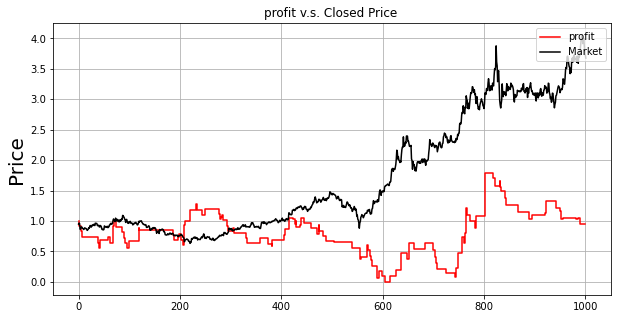

持有時間比例:0.0, strategy return vs by&hold :-0.019927639763555542, 資金效率:-inf
0.059880385533739096
profit :0.2 , loss:-0.075 , day :5 , out : 0.01894396948523365, total_trade : 76


C:\Users\kevin\AppData\Local\Temp/ipykernel_14944/2952922852.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  print("持有時間比例:{}, strategy return vs by&hold :{}, 資金效率:{}".format(time_ratio,retun_ratio,retun_ratio/time_ratio ))


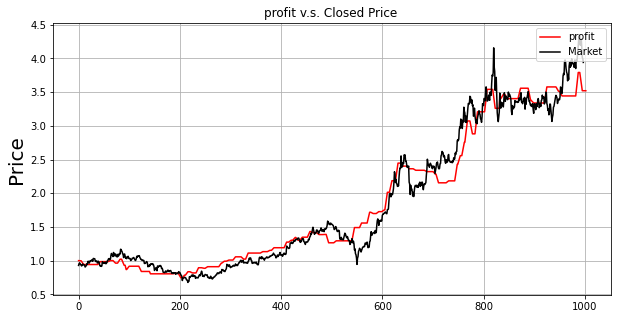

持有時間比例:0.37735849056603776, strategy return vs by&hold :0.8574526677969639, 資金效率:2.2722495696619545


In [449]:
index = 0
for i in range(2):
    if i == 0:
        停利 = day_trade.p[index]
        停損 = day_trade.l[index]*-1
        d=day_trade.d[index]
    else :
        停利 = swing.p[index]
        停損 = swing.l[index]*-1
        d=swing.d[index]
        
    if (d==0):
        fee = 0.0015+0.0029*0.3
    else :
        fee = 0.003+0.0029*0.3
    return_ = 1-fee
    short_shres = -1
    long_shres = 0
    estimate_return(short_shres,long_shres)
#     estimate_compound_return(short_shres,long_shres)